# RL-controlled adaptive time stepping (user-defined)

This notebook shows how to wrap `Solve_IVP_NS` in a reinforcement-learning

workflow. The reward, observation mapping, and policy configuration are

constructed directly in the notebook and are **not** part of the public API.

They are intended as one possible example only; feel free to adapt or replace

them for your own experiments. Running this notebook is optional and not

required for installing, testing, or using the core solver package.


In [20]:
from plants.faults import strikeslip
import os

import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import time



In [21]:
import autograd.numpy as anp
from scipy.optimize import root
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import time 

import torch as th
from torch import nn
from stable_baselines3.td3.policies import TD3Policy
from stable_baselines3.sac.policies import SACPolicy  
from stable_baselines3.common.vec_env import VecNormalize
import gymnasium as gym
from gymnasium import spaces

from sb3_contrib import TQC
from stable_baselines3 import TD3, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from Solve_IVP_NS.rl.env import AdaptiveStepperEnv
from Solve_IVP_NS.rl.callbacks import RewardCallback, CustomMetricsCallback

sizes = 30
plt.rcParams.update({
    'font.size': sizes,
    'axes.titlesize': sizes,
    'axes.labelsize': sizes,
    'xtick.labelsize': sizes,
    'ytick.labelsize': sizes,
    'legend.fontsize': sizes,
    'figure.titlesize': sizes,
    'text.usetex': True,
    'font.family': 'Times',
    # Embed fonts in vector outputs so text is editable
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    # Keep LaTeX preamble minimal to prevent bloat and ensure Times math
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{mathptmx}',
    # Cleaner default look; we'll style axes explicitly in plotting code
    'axes.grid': False,
})


import Solve_IVP_NS  # Ensure that this module is in your PYTHONPATH
th.set_default_dtype(th.float32)

In [22]:
from pathlib import Path
DATA_DIR = str((Path.cwd() / "Data").resolve())
print(f"Loading: {DATA_DIR}/kijs_2x2elem-3x3length.npy")

# Initialize fault model
fault = strikeslip.qs_strikeslip_fault(
    zdepth=3, xlength=3, Nz=30, Nx=30,  
    G=30000., rho=2.5e-3, zeta=0.8/3, 
    Ks_path="./Data/", gamma_s=25., gamma_w=10., 
    sigma_ref=100., depth_ini=0., vinf=3.171e-10, 
    Dmu_estimate=.5,
)

# Get plant parameters
MA, KS, ES, SIGMA_N, VINF_raw = fault.get_plant()

# Print diagnostic information
print(f"Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: {KS.sum()}")
print(f"Approximate value of total stiffness assuming a patch of length Lx: {3.333333333333333e-07}")
print(f"Calculated value: {3.962559156372552e-07}")
print(f"Units are in: mm,N,ms,MPa,gr")

Loading: /home/david/Documents/Solve_ivp_ns/RL_Adaption/2D_FAULT/Data/kijs_2x2elem-3x3length.npy
Loading: ./Data/kijs_30x30elem-3x3length.npy
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz:  3.501230118388745e-07
Approximate value of total stiffness assuming a patch of length Lx:  3.333333333333333e-07
Calculated value:  9.155445389490453e-07
Units are in: mm,N,ms,MPa,gr
Theoretical value of total stiffness assuming a patch of dimensions Lx x Lz: 1182.7151815294349
Approximate value of total stiffness assuming a patch of length Lx: 3.333333333333333e-07
Calculated value: 3.962559156372552e-07
Units are in: mm,N,ms,MPa,gr


In [23]:
import scipy.sparse as sp

N_DOFS = fault.N                                # int
VINF = VINF_raw * np.ones(N_DOFS)*0               # scalar vinf

# Sparse block matrix for the solver (CSR)
# A = block_diag([MA, I, I]) with zeros off the block-diagonals
I_N = sp.eye(N_DOFS, format='csr')
A = sp.block_diag([sp.csr_matrix(MA), I_N, I_N], format='csr')

# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]

print(f')

In [24]:
import math
from numba import njit

KS_dense = np.ascontiguousarray(KS, dtype=np.float64)
ES_dense = np.ascontiguousarray(ES, dtype=np.float64)
VINF_vec = np.ascontiguousarray(VINF, dtype=np.float64)

_rhs_buffer = np.empty(3 * N_DOFS, dtype=np.float64)
_rhs_jac_buffer = np.zeros((3 * N_DOFS, 3 * N_DOFS), dtype=np.float64)

@njit(cache=True)
def _rhs_kernel(y, KS, ES, VINF, out):
    n = VINF.shape[0]
    for i in range(n):
        sum_ku = 0.0
        sum_ev = 0.0
        yi = y[i]
        for j in range(n):
            sum_ku += KS[i, j] * y[n + j]
            sum_ev += ES[i, j] * (y[j] - VINF[j])
        out[i] = -(sum_ku + sum_ev)
        out[n + i] = yi - VINF[i]
        out[2 * n + i] = yi if yi >= 0.0 else -yi

def rhs(t, y):
    _rhs_kernel(y, KS_dense, ES_dense, VINF_vec, _rhs_buffer)
    return _rhs_buffer.copy()

def rhs_jac(t, y, Fk_val=None):
    n = N_DOFS
    jac = _rhs_jac_buffer
    jac.fill(0.0)
    jac[:n, :n] = -ES_dense
    jac[:n, n:2 * n] = -KS_dense
    rows_primary = n + np.arange(n)
    jac[rows_primary, np.arange(n)] = 1.0
    slip_signs = np.sign(y[:n]).astype(np.float64)
    jac[2 * n + np.arange(n), np.arange(n)] = slip_signs
    return jac.copy()

In [25]:
DMU = -0.1   # Friction drop amount (adjust based on your problem)
DC = 100.0 / fault.Dscale    # Characteristic slip distance (adjust based on your problem)
MU_RES = 0.5

SIGMA_N_vec = np.ascontiguousarray(SIGMA_N, dtype=np.float64)

_con_force_buffer = np.zeros(3 * N_DOFS, dtype=np.float64)
_con_force_jac_buffer = np.zeros((3 * N_DOFS, 3 * N_DOFS), dtype=np.float64)

@njit(cache=True)
def _con_force_kernel(state, sigma_n, mu_res, dmu, dc, out):
    n = sigma_n.shape[0]
    for i in range(n):
        slip_i = state[2 * n + i]
        mu_val = mu_res * (1.0 - (dmu / mu_res) * math.exp(-slip_i / dc))
        out[i] = mu_val * sigma_n[i]

@njit(cache=True)
def _con_force_jac_kernel(state, sigma_n, dmu, dc, out):
    n = sigma_n.shape[0]
    for i in range(n):
        slip_i = state[2 * n + i]
        dmu_dslip = (dmu / dc) * math.exp(-slip_i / dc)
        out[i, 2 * n + i] = sigma_n[i] * dmu_dslip

def con_force(state, fk=None):
    _con_force_buffer.fill(0.0)
    _con_force_kernel(state, SIGMA_N_vec, MU_RES, DMU, DC, _con_force_buffer)
    return _con_force_buffer.copy()


def con_force_jacobian(state, t=None, Fk_val=None):
    _con_force_jac_buffer.fill(0.0)
    _con_force_jac_kernel(state, SIGMA_N_vec, DMU, DC, _con_force_jac_buffer)
    return _con_force_jac_buffer.copy()


In [26]:
# projection and solver options
projection_opts = {
    'con_force_func': con_force,
    'rhok': np.ones(N_DOFS, dtype=float),
    'component_slices': component_slices,
    'constraint_indices': np.arange(N_DOFS, dtype=np.int32),
    # 'jac_func': con_force_jacobian,  # analytical Jacobian for CoulombProjection

}

# Tuned nonlinear-solver options shared by VI and SSN
solver_opts_common = dict(
    tol=1e-8,
    max_iter=200,
    rhs_jac=rhs_jac,      # enables exact residual Jacobian in integrators
    # linear_solver='dense',
    # use_broyden=True,
    # adaptive_lam = False
 )

# Adaptive controller tuned for nonsmooth dynamics
adaptive_opts = dict(
    h0=5e-2,
    h_min=1e-7,
    h_down=0.6,
    h_up=1.8,
    method_order=1,           # conservative order for nonsmooth dynamics
    skip_error_indices=[],
    controller='h211b',              # smoother steps with PI control
    b_param=4.0,         # only if controller == "H211b"
    mode = 'ratio'

 )

# SSN-specific tweaks for robustness and speed
solver_opts_ssn = dict(solver_opts_common)
solver_opts_ssn.update({
    "vi_strict_block_lipschitz": False,   # was True by default
    "vi_max_block_adjust_iters": 5,       # smaller safety cap
    "globalization": 'line_search',    # more robust globalization
})


In [27]:
y0 = np.zeros(3 * N_DOFS)
friction_force = con_force(y0)
uc = -np.linalg.solve(KS,friction_force[:N_DOFS]) #displacement at frictional instability

u0 = uc * (1 + 1e-5) # peturb uc displacement slighty

y0[ N_DOFS : 2 * N_DOFS] = u0
Uint =  0.5 * np.dot(u0, KS @ u0) #initial internal energy
Uintc =  0.5 * np.dot(uc, KS @ uc) # internal energy at frictional instability used to normalize energy


# print(f"Initial slip values (s0): {u0}")
# print(f"Initial state (y0): {y0}")

In [28]:
# === Full semismooth Newton solves: pure Python vs Numba, plus BDF reference ===
# We run the full integrator twice, once forcing pure Python (use_numba=False)
# and once forcing Numba acceleration (use_numba=True). Then we also solve
# the regularized smooth problem with SciPy's BDF for comparison.
tmax=  30 * fault.second / fault.Tscale

t_span = (0.0, tmax)
# # Make a copy of base solver opts for semismooth Newton
# solver_opts_ssn = solver_opts.copy()
# solver_opts_ssn['max_iter'] = 100


projection_opts_nb = dict(projection_opts)
projection_opts_nb['use_numba'] = True   # force Numba path



# --- Semismooth Newton (Numba) ---
start_nb = time.time()
(t_vals_ssn_nb,
 y_vals_ssn_nb,
 h_vals_ssn_nb,
 fk_vals_ssn_nb,
 solver_info_ssn_nb) = Solve_IVP_NS.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=y0,
    method='composite',
    projection='coulomb',
    solver='VI',
    projection_opts=projection_opts_nb,
    solver_opts=solver_opts_ssn,
    adaptive=True,
    adaptive_opts=adaptive_opts,
    # atol=1e-8,
    # rtol=1e-6,
    h0=30/4 * fault.second / fault.Tscale,
    component_slices=component_slices,
    verbose=True,
    A=A
)
rt_nb = time.time() - start_nb
print(f"Semismooth (Numba)  solve complete in {rt_nb:.3f} s")

# Keep backward-compatible variable nams for downstream post-processing.
# We choose the Numba result as the primary (you can swap to *_py if you prefer).
t_vals_ssn = t_vals_ssn_nb
y_vals_ssn = y_vals_ssn_nb
h_vals_ssn = h_vals_ssn_nb
y_fk_vals_placeholder = fk_vals_ssn_nb  # not used directly, keep for clarity
fk_vals_ssn = fk_vals_ssn_nb



coulomb
[adaptive] accept @ t=0 -> t+5.000e-02, E=2.056e-01, h_next=9.000e-02
[adaptive] accept @ t=0.05 -> t+9.000e-02, E=6.436e-01, h_next=1.297e-01
[adaptive] reject @ t=0.14, E=1.563e+00, h_curr=1.297e-01 -> h_next=7.781e-02
[adaptive] accept @ t=0.14 -> t+7.781e-02, E=5.875e-01, h_next=9.213e-02
[adaptive] accept @ t=0.217812 -> t+9.213e-02, E=8.701e-01, h_next=9.683e-02
[adaptive] accept @ t=0.309945 -> t+9.683e-02, E=9.965e-01, h_next=8.971e-02
[adaptive] accept @ t=0.406773 -> t+8.971e-02, E=8.797e-01, h_next=8.451e-02
[adaptive] accept @ t=0.496488 -> t+8.451e-02, E=7.941e-01, h_next=8.459e-02
[adaptive] accept @ t=0.580996 -> t+8.459e-02, E=8.022e-01, h_next=8.612e-02
[adaptive] accept @ t=0.665586 -> t+8.612e-02, E=8.352e-01, h_next=8.627e-02
[adaptive] accept @ t=0.751704 -> t+8.627e-02, E=8.416e-01, h_next=8.550e-02
[adaptive] accept @ t=0.837975 -> t+8.550e-02, E=8.297e-01, h_next=8.503e-02
[adaptive] accept @ t=0.923473 -> t+8.503e-02, E=8.226e-01, h_next=8.506e-02
[adap

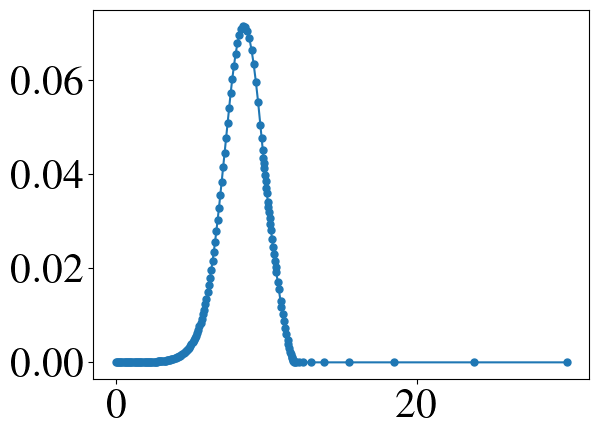

In [31]:
# plt.plot(t_vals_ssn * fault.Tscale / fault.second, np.mean(y_vals_ssn[:,:N_DOFS],axis=1) * fault.Vscale, label='Velocity (ssn)')
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (m/s)')
# plt.title('Velocity vs Time (SSN)')
# # plt.legend()
# plt.grid()
# plt.show()

# plt.plot(t_vals_ssn * fault.Tscale / fault.second,y_vals_ssn[:,:N_DOFS] * fault.Vscale, label='Velocity (ssn)')
# plt.xlabel('Timemarkert# .ylabel('Velocity (m/s)')
plt# .title('Velocity vs Time (SSN)')
# p# lt.legend()
plt# .grid()
plt# .show()
t_scaled = t_vals_ssn * fault.Tscale / fault.second
mean_vel = np.mean(y_vals_ssn[:, :N_DOFS], axis=1) * fault.Vscale

plt.plot(t_scaled, mean_vel, linestyle='-', color='C0', label='Velocity (ssn)')
plt.scatter(t_scaled, mean_vel, color='C0', s=25)  # one marker per time point

In [11]:
t_vals_ssn[-1] * fault.Tscale / fault.second

np.float64(30.0)

In [12]:
# results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
# v_max = results['kb_estimate']
# print(v_max)
# # print(0.07/fault.Vscale)

In [13]:
import numpy as np
# # alpha_reference = 2.0  # legacy default retained for reference
# results = estimate_v_max_range(y0, KS, ES, SIGMA_N, MU_RES, DMU, DC, VINF)
# v_max = results['kb_estimate']
# # print(v_max)


import numpy as np

def build_reward_fn(alpha_value: float):
    """
    Build a reward function parameterized by alpha_value.

    alpha_value controls how harshly we punish numerical error via A = exp(-alpha*E).
    Larger alpha_value => more accuracy-obsessed agent.
    """

    alpha_value = float(alpha_value)

    def my_reward_fn(solver_perf, dt_attempt, xk, env):
        # solver_perf layout from env.increment_env:
        # [ runtime_inc,
        #   dts,
        #   error_LO,
        #   error_lil1,
        #   error_HI,
        #   E,                # global RMS scaled error
        #   success_LO,
        #   success_lil1,
        #   success_HI,
        #   kiter_LO,
        #   iter_lil1,
        #   kiter_HI ]
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E,
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        # We'll need this a few times
        dt_range = env.dt_max - env.dt_min

        # If the integrator did not advance time (reject / failure path):
        # dts will be 0.0, success flags likely False.
        if dts == 0.0:
            # Penalize requesting a too-large step that got rejected.
            # Normalize dt_attempt to [0,1] and assign negative reward.
            dt_norm_attempt = (dt_attempt - env.dt_min) / dt_range
            # Clip to be safe
            # dt_norm_attempt = float(np.clip(dt_norm_attempt, 0.0, 1.0))
            # print(f" Step rejected. dt_attempt: {dt_attempt}, dt_norm_attempt: {dt_norm_attempt}")
            return -dt_norm_attempt  # more aggressive ask that failed => more negative

        # Otherwise: this step was accepted and advanced time by dts.

        # -----------------
        # S1: step size score
        # -----------------
        # We reward taking a large *accepted* step.
        dt_norm = (dts - env.dt_min) / dt_range
        S1 = float(np.clip(dt_norm, 0.0, 1.0))

        # -----------------
        # S2: runtime score
        # -----------------
        # Track per-step runtime and update the running maximum to normalize S2 dynamically
        if not hasattr(env, 'runtime_history'):
            env.runtime_history = []
        env.runtime_history.append(float(runtime_inc))

        # Maintain a running max runtime seen so far
        if not hasattr(env, 'max_runtime_seen'):
            env.max_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc > env.max_runtime_seen:
                env.max_runtime_seen = float(runtime_inc)
        # track min as well as max
        if not hasattr(env, 'min_runtime_seen'):
            env.min_runtime_seen = float(runtime_inc)
        else:
            if runtime_inc < env.min_runtime_seen:
                env.min_runtime_seen = float(runtime_inc)
        # Compute S2 using the dynamic max; clamp denominator to avoid division by zero
        rt_min =  float(env.min_runtime_seen)
        rt_max = max(rt_min, float(env.max_runtime_seen))
        denom = max(1e-8, rt_max - rt_min)
        S2 = 1 - (float(runtime_inc) - rt_min) / denom

        A = float(np.exp(-alpha_value * E))
        # print(f" S1: {S1}, S2: {S2},  A: {A}")
        # Final reward
        reward = S1 * S2 * A
        return reward

    return my_reward_fn



def build_obs_fn(alpha_value: float):
    """
    Factory that returns an observation function using the SAME alpha as the reward.
    This keeps reward shaping and observation aligned.

    The returned function will be called as:
        obs_fn(dt_attempt, converged, xk, solver_perf, fk, env)

    Where:
      - dt_attempt: the candidate step the agent just asked for (float or None at reset)
      - converged: 1 if the accepted high-accuracy solve succeeded, else 0 (None at reset)
      - xk: current state vector after the env step (or initial state at reset)
      - solver_perf: list of solver diagnostics from env.increment_env(...) (None at reset)
      - fk: current residual (not used here, but passed in by env)
      - env: the AdaptiveStepperEnv instance
    """
    alpha_value = float(alpha_value)

    def my_obs_fn(dt_attempt, converged, xk, solver_perf, fk=None, env=None):
        assert env is not None, "env must be provided by AdaptiveStepperEnv"

        # ------------------------------------------------------------------
        # 1. Extract physics state features from xk
        # ------------------------------------------------------------------
        n = N_DOFS  # assuming N_DOFS is defined in outer scope
        v = xk[:n]          # velocities / slip rates
        u = xk[n:2*n]       # displacements / slips

        avg_v = float(np.mean(v))

        # Internal elastic energy 0.5 * u^T K u
        ks_u = KS @ u       # KS must be defined in outer scope
        E_int = 0.5 * float(np.dot(u, ks_u))

        # Normalize internal energy by Uintc (critical energy), if available and >0
        try:
            if Uintc > 0.0:
                E_norm = float(E_int / Uintc)
            else:
                E_norm = float(E_int)
        except NameError:
            # Fallback if Uintc isn't in scope
            E_norm = float(E_int)

        if solver_perf is not None:
            dts = solver_perf[1]
            conv_flag_bipolar = 1.0 if dts > 0.0 else -1.0
        else:
            conv_flag_bipolar = -1.0
        # ------------------------------------------------------------------
        # 2. Reset branch (env.reset calls us with dt_attempt=None, solver_perf=None)
        # ------------------------------------------------------------------
        if dt_attempt is None or solver_perf is None:
            # We still return a valid 6-D observation vector.
            # Fill in placeholders for solver-derived quantities.
            dt_norm_default = 0.5  # neutral midpoint in [0,1]
            conv_flag = 0.0 if converged is None else float(converged)

            return np.array([
                E_norm,                # elastic energy normalized
                avg_v / (0.07/fault.Vscale),         # avg slip rate normalized (v_max provided externally)
                (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
                conv_flag,             # "converged" flag at reset (0 or None -> 0)
                0.0,                   # exp(-alpha * 0) = 1.0 as a neutral accuracy proxy
                conv_flag_bipolar * dt_norm_default,       # normalized dt ~ mid
            ], dtype=np.float64)

        # ------------------------------------------------------------------
        # 3. Normal step branch: unpack solver_perf
        # ------------------------------------------------------------------
        (
            runtime_inc,
            dts,
            error_LO,
            error_lil1,
            error_HI,
            E_global,        # global RMS scaled error (Richardson)
            success_LO,
            success_lil1,
            success_HI,
            kiter_LO,
            iter_lil1,
            kiter_HI,
        ) = solver_perf

        # ------------------------------------------------------------------
        # 4. Normalize dt_attempt into [0,1]
        # ------------------------------------------------------------------
        dt_range = env.dt_max - env.dt_min
        if dt_range <= 0.0:
            dt_norm = 0.0
        else:
            dt_norm = (dt_attempt - env.dt_min) / dt_range
            dt_norm = float(np.clip(dt_norm, 0.0, 1.0))

        # ------------------------------------------------------------------
        # 5. Accuracy proxy, aligned with reward shaping
        # ------------------------------------------------------------------
        # 6. Convergence flag
        # ------------------------------------------------------------------
        # env.step sets converged = 1 if dts > 0 else 0 before calling obs_fn.
        conv_flag = float(converged) if converged is not None else 0.0
        if conv_flag:
            acc = 1/(1 + E_global)
        else:
            # print(f"Not converged step detected in obs_fn.")
            acc = 0.0

        # print(f"E_norm: {E_norm}, avg_v/v_max: {avg_v / v_max}, iter_error: {(env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0}, conv_flag: {conv_flag}, acc: {acc}, dt_norm: {dt_norm}")
        # ------------------------------------------------------------------
        # 7. Assemble observation vector
        # ------------------------------------------------------------------
        # print(f"observed step {conv_flag_bipolar*dt_norm}")
        return np.array([
            E_norm,                        # normalized elastic energy
            avg_v / (0.07/fault.Vscale),                 # normalized average slip rate
            (env.iter_error / 4.0) if hasattr(env, 'iter_error') else 0.0,
            conv_flag,                     # 1 if high-accuracy solve accepted, else 0
            acc,                   # exp(-alpha * error), same shaping as reward
            conv_flag_bipolar *dt_norm,                       # normalized proposed dt in [0,1]
        ], dtype=np.float64)

    return my_obs_fn


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from stable_baselines3.common.callbacks import BaseCallback

class RewardCallback(BaseCallback):
    def __init__(
        self,
        Vscale=1.0,
        Dscale=1.0,
        Tscale=1.0,
        update_freq=50,
        offset_increment=10.0,
        num_envs=1,
        verbose=0,
    ):
        """
        Live training monitor for SB3 in Jupyter.

        Panels per env:
          (0) step-by-step reward trace, with green vertical lines at episode ends
          (1) per-episode return
          (2) avg_v (green, left y) and avg_u (blue, right y) vs physical time t_k1,
              zoomed to last ~2-3 episodes
          (3) steps_per_episode (here we record Sim_time at episode end)

        Vscale, Dscale, Tscale are just multiplicative scalars in case your units
        are nondimensional internally and you want to rescale for plotting.
        """
        super().__init__(verbose)
        self.update_freq = int(update_freq)
        self.offset_increment = float(offset_increment)

        self.Vscale = float(Vscale)  # scales avg_v
        self.Dscale = float(Dscale)  # scales avg_u
        self.Tscale = float(Tscale)  # not currently used in plot, reserved

        # will get overwritten in _init_callback
        self.num_envs = int(num_envs)

        # buffers (will be resized in _init_callback)
        self.rewards = None
        self.episode_rewards = None
        self.current_episode_rewards = None

        self.avg_v_values = None
        self.avg_u_values = None
        self.t_k1_values = None

        self.steps = None
        self.episodes = None
        self.episode_end_steps = None
        self.episode_end_indices = None
        self.current_offsets = None
        self.steps_per_episode = None

        self.fig = None
        self.axs = None     # shape [num_envs][4]
        self.axs2 = None    # list of twin y-axes, len = num_envs

    def _init_callback(self) -> None:
        """Called by SB3 at the beginning of .learn()."""
        # detect actual number of envs from VecEnv
        self.num_envs = getattr(self.training_env, "num_envs", 1)

        # allocate buffers for each env
        self.rewards = [[] for _ in range(self.num_envs)]               # step-wise reward
        self.episode_rewards = [[] for _ in range(self.num_envs)]       # per-episode return
        self.current_episode_rewards = [0.0] * self.num_envs            # running sum this ep

        self.avg_v_values = [[] for _ in range(self.num_envs)]          # avg_v trace
        self.avg_u_values = [[] for _ in range(self.num_envs)]          # avg_u trace
        self.t_k1_values  = [[] for _ in range(self.num_envs)]          # physical time trace (offset per ep)

        self.steps = [0] * self.num_envs
        self.episodes = [0] * self.num_envs

        self.episode_end_steps   = [[] for _ in range(self.num_envs)]   # x-locations of ep ends in panel 0
        self.episode_end_indices = [[] for _ in range(self.num_envs)]   # indices for trimming panel 2
        self.current_offsets     = [0.0] * self.num_envs                # time offset added after each ep
        self.steps_per_episode   = [[] for _ in range(self.num_envs)]   # store Sim_time snapshot at ep end

        # set up figure
        self.fig, self.axs = plt.subplots(self.num_envs, 4, figsize=(25, 5 * self.num_envs))
        if self.num_envs == 1:
            # normalize shape so we can always index axs[i][col]
            self.axs = [self.axs]

        # make twin y-axes for avg_u in panel (2)
        self.axs2 = []
        for i in range(self.num_envs):
            # panel 0: reward vs steps
            self.axs[i][0].set_xlabel("Steps")
            self.axs[i][0].set_ylabel("Reward")
            self.axs[i][0].axhline(y=0, color="r", linestyle="--")

            # panel 1: per-episode return
            self.axs[i][1].set_xlabel("Episodes")
            self.axs[i][1].set_ylabel("Total Reward")

            # panel 2: avg_v / avg_u vs t_k1
            self.axs[i][2].set_xlabel("t_k1")
            self.axs[i][2].set_ylabel("avg_v", color="g")
            self.axs[i][2].tick_params(axis="y", labelcolor="g")
            self.axs[i][2].grid(True)

            # panel 3: steps_per_episode
            self.axs[i][3].set_xlabel("Episodes")
            self.axs[i][3].set_ylabel("Steps per Episode / Sim_time")

            ax2 = self.axs[i][2].twinx()
            ax2.set_ylabel("avg_u", color="b")
            ax2.tick_params(axis="y", labelcolor="b")
            self.axs2.append(ax2)

        display(self.fig)

    def _on_step(self) -> bool:
        """
        Called by SB3 every environment step (actually every rollout collection step).

        We read self.locals["rewards"], self.locals["dones"], self.locals["infos"].
        With VecEnv:
            rewards -> np.array shape (n_envs,)
            dones   -> np.array shape (n_envs,)
            infos   -> list[dict] length n_envs
        With single env:
            they can be scalars/dicts; we wrap them to lists.
        """
        rewards = self.locals["rewards"]
        dones   = self.locals["dones"]
        infos   = self.locals["infos"]

        # unify shape for num_envs==1
        if self.num_envs == 1 and not isinstance(rewards, (list, tuple, np.ndarray)):
            rewards = [rewards]
            dones   = [dones]
            infos   = [infos]

        for i in range(self.num_envs):
            r_i = float(rewards[i])
            self.rewards[i].append(r_i)
            self.current_episode_rewards[i] += r_i
            self.steps[i] += 1

            info_i = infos[i]


            xk = info_i.get("xk", None)
            if xk is not None:
                n = N_DOFS
                v = xk[:n]* self.Vscale
                u = xk[n:2*n]* self.Dscale
            #     mean_vel.append(float(np.mean(v)))
            # mean_slip.append(float(np.mean(u)))

            # # pull diagnostics from env.info
            # # we scaled in env.step(), now we optionally rescale for plotting
            # avg_v_i  = float(info_i.get("avg_v", 0.0)) * self.Vscale
            # avg_u_i  = float(info_i.get("avg_u", 0.0)) * self.Dscale
            t_k1_i   = float(info_i.get("t_k1", 0.0))
            sim_time = float(info_i.get("Sim_time", 0.0))

            # append traces
            self.avg_v_values[i].append(float(np.mean(v)))
            self.avg_u_values[i].append(float(np.mean(u)))
            # add offset to make t_k1 increase monotonically across episodes
            self.t_k1_values[i].append(t_k1_i + self.current_offsets[i])

            # handle episode boundary
            if dones[i]:
                # store episode return
                self.episode_rewards[i].append(self.current_episode_rewards[i])
                # mark step index where this episode ended
                self.episode_end_steps[i].append(len(self.rewards[i]))
                # mark index in avg_v_values so we can "zoom to last 2-3 episodes"
                self.episode_end_indices[i].append(len(self.avg_v_values[i]))

                # snapshot "steps per episode" panel: we're using sim_time here
                self.steps_per_episode[i].append(sim_time)

                # reset accumulators for next ep
                self.current_episode_rewards[i] = 0.0
                self.episodes[i] += 1
                self.steps[i] = 0

                # bump offset so next episode's t_k1 timeline is shifted forward
                if self.t_k1_values[i]:
                    last_t = self.t_k1_values[i][-1]
                    self.current_offsets[i] = last_t + self.offset_increment

        # redraw occasionally
        total_steps_all_envs = sum(self.steps)
        if (total_steps_all_envs % self.update_freq) == 0:
            self._update_plot()

        return True

    def _update_plot(self):
        """Refresh the 4-panel figure for each env."""
        for i in range(self.num_envs):
            # clear each panel
            self.axs[i][0].cla()
            self.axs[i][1].cla()
            self.axs[i][2].cla()
            self.axs2[i].cla()
            self.axs[i][3].cla()

            # (0) reward per step, with episode boundaries
            self.axs[i][0].plot(self.rewards[i], "b-")
            self.axs[i][0].set_xlabel("Steps")
            self.axs[i][0].set_ylabel("Reward")
            self.axs[i][0].axhline(y=0, color="r", linestyle="--")
            for step_idx in self.episode_end_steps[i]:
                self.axs[i][0].axvline(x=step_idx, color="g", linestyle="--")

            # (1) episode return
            if len(self.episode_rewards[i]) > 1:
                self.axs[i][1].plot(
                    self.episode_rewards[i][1:],
                    color="r",
                    marker="o",
                    linestyle="-",
                )
            self.axs[i][1].set_xlabel("Episodes")
            self.axs[i][1].set_ylabel("Total Reward")

            # choose window for panel (2): last ~2-3 episodes
            if len(self.episode_end_indices[i]) >= 3:
                start_index = self.episode_end_indices[i][-3]
            elif len(self.episode_end_indices[i]) == 2:
                start_index = self.episode_end_indices[i][-2]
            else:
                start_index = 0
            end_index = len(self.avg_v_values[i])

            # (2) avg_v vs physical time
            self.axs[i][2].plot(
                self.t_k1_values[i][start_index:end_index],
                self.avg_v_values[i][start_index:end_index],
                color="g",
                marker="o",
                linestyle="-",
                label="avg_v",
            )
            self.axs[i][2].set_xlabel("t_k1")
            self.axs[i][2].set_ylabel("avg_v", color="g")
            self.axs[i][2].tick_params(axis="y", labelcolor="g")
            self.axs[i][2].grid(True)

            # (2 twin) avg_u vs physical time
            self.axs2[i].plot(
                self.t_k1_values[i][start_index:end_index],
                self.avg_u_values[i][start_index:end_index],
                color="b",
                marker="x",
                linestyle="--",
                label="avg_u",
            )
            self.axs2[i].set_ylabel("avg_u", color="b")
            self.axs2[i].tick_params(axis="y", labelcolor="b")

            # combined legend
            lines_1, labels_1 = self.axs[i][2].get_legend_handles_labels()
            lines_2, labels_2 = self.axs2[i].get_legend_handles_labels()
            self.axs[i][2].legend(
                lines_1 + lines_2,
                labels_1 + labels_2,
                loc="upper left",
            )

            # (3) steps_per_episode (we're storing Sim_time snapshots)
            if len(self.steps_per_episode[i]) > 1:
                self.axs[i][3].plot(self.steps_per_episode[i][1:], "b-")
            self.axs[i][3].set_xlabel("Episodes")
            self.axs[i][3].set_ylabel("Steps per Episode / Sim_time")

        clear_output(wait=True)
        display(self.fig)


In [15]:
from Solve_IVP_NS.projections import CoulombProjection
from Solve_IVP_NS.nonlinear_solvers import ImplicitEquationSolver
from Solve_IVP_NS.integrations import CompositeMethod, Trapezoidal
from Solve_IVP_NS.ODESystem import ODESystem
from Solve_IVP_NS.ODESolver import ODESolver
from Solve_IVP_NS.rl.callbacks import CustomMetricsCallback
from gymnasium import spaces
from pathlib import Path
import json
from copy import deepcopy

from stable_baselines3.common.noise import NormalActionNoise


# Component slices (each DOF separately) and constraint indices (only DOF 0 is constrained)
# Component slice layout
component_slices = [
    slice(0, N_DOFS),
    slice(N_DOFS, 2 * N_DOFS),
    slice(2 * N_DOFS, 3 * N_DOFS)
]
component_slices_solver = [slice(0, 3 * N_DOFS)]  # solver works on full state vector
# For constrained DOF 0 we set rhok=1.0; unconstrained DOF 1 gets 0.
rhok = np.ones(N_DOFS, dtype=float)

# Create the projection operator
projection = CoulombProjection(
    con_force_func=con_force,
    rhok=rhok,
    component_slices=component_slices,
    constraint_indices=np.arange(N_DOFS, dtype=np.int32),
    use_numba=True,  # use Numba acceleration
    jac_func=con_force_jacobian,  # analytical Jacobian for CoulombProjection
)

# Configure the implicit solver
solver_mp = ImplicitEquationSolver(
    method='VI',
    proj=projection,
    component_slices=component_slices,
    tol=solver_opts_ssn.get('tol', 1e-6),
    max_iter=solver_opts_ssn.get('max_iter', 50),
    vi_strict_block_lipschitz=solver_opts_ssn.get("vi_strict_block_lipschitz", False),
    vi_max_block_adjust_iters=solver_opts_ssn.get("vi_max_block_adjust_iters", 10),
)
solver_mp.rhs_jacobian = rhs_jac  # expose analytical RHS Jacobian to integrators

# Use the composite method (which calls the solver internally)
method_mp = CompositeMethod(solver=solver_mp, A=A)



# --- Adaptive RL training over an alpha sweep ---
# Here we iterate over a list of alpha values, train a policy for each,
# and persist the resulting models, normalization stats, and metadata
# into per-alpha subdirectories for easy organization.
dt0 = 1e-3
t0 = t_span[0]
tnmax = t_span[1]
dt_min = 1e-6  # * fault.second / fault.Tscale
dt_max = 30 / 5 * fault.second / fault.Tscale
nparams = (1e-6, 100)

# Define the observation space (here we use the 3 state variables plus 3 extra features regarding solver performance)
obs_dim = 6
obs_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float64)

# alpha_grid = [0.5, 1.0, 2.0, 4.0,8.0, 16.0, 32.0, 128.0]  # customize as desired
# alpha_grid = [ 32.0, 128.0]  # customize as desired

alpha_grid = [8.0]  # customize as desired

total_timesteps = 20_000
RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP")
RUN_ROOT.mkdir(parents=True, exist_ok=True)

def _alpha_label(alpha_value: float) -> str:
    sign = "m" if alpha_value < 0 else ""
    magnitude = str(abs(alpha_value)).replace(".", "p")
    return f"{sign}{magnitude}"

_base_policy_kwargs = dict(
    activation_fn=th.nn.ReLU,
    net_arch=dict(pi=[64, 64], qf=[64, 64, 64], n_critics=5)
)



In [16]:
reward_callback = RewardCallback(num_envs=1,Vscale = fault.Vscale, Dscale = fault.Dscale, Tscale = fault.Tscale/fault.second, update_freq=100)




In [17]:
# def _policy_kwargs():
#     return dict(_base_policy_kwargs)

# def _build_tqc(vec_env):
#     return TQC(
#         "MlpPolicy",
#         vec_env,
#         batch_size=256,
#         use_sde=True,
#         verbose=0,
#         policy_kwargs=_policy_kwargs())

# def _build_td3(vec_env):
#     # The noise objects for TD3
#     n_actions = vec_env.action_space.shape[-1]
#     action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
#     return TD3(
#         "MlpPolicy",
#         vec_env,
#         batch_size=256,
#         verbose=0,
#         action_noise=action_noise,
#         policy_kwargs=_policy_kwargs())

# algorithms = {
#     "TQC": dict(builder=_build_tqc),
#     # "TD3": dict(builder=_build_td3),
# }

# for alpha_value in alpha_grid:
#     print("=" * 60)
#     print(f"Preparing training runs with alpha = {alpha_value}")
#     alpha_dir = RUN_ROOT / f"alpha_{_alpha_label(alpha_value)}"
#     alpha_dir.mkdir(parents=True, exist_ok=True)

#     reward_fn = build_reward_fn(alpha_value)
#     obs_fn = build_obs_fn(alpha_value)

#     def make_env():
#         return AdaptiveStepperEnv(
#             system=rhs,
#             dt0=dt0,
#             t0=t0,
#             x0=y0,
#             tnmax=tnmax,
#             dt_min=dt_min,
#             dt_max=dt_max,
#             nparams=nparams,
#             integrator=method_mp,
#             component_slices=component_slices,
#             reward_fn=reward_fn,
#             obs_fn=obs_fn,
#             obs_space=obs_space,
#             verbose=False,
#             # atol=1e-9,
#             # rtol=1e-6,
#             alpha=alpha_value,  # ensure env.alpha matches this run's alpha
# )

#     for algo_name, algo_cfg in algorithms.items():
#         print("-" * 60)
#         print(f"Training {algo_name} adaptive controller with alpha = {alpha_value}")
#         vec_env = DummyVecEnv([make_env])
#         vec_env = VecNormalize(vec_env, norm_obs=False, norm_reward=False)
#         model = algo_cfg["builder"](vec_env)

#         metrics_callback = CustomMetricsCallback()
#         start_time = time.time()
#         model.learn(total_timesteps=total_timesteps, callback=[reward_callback, metrics_callback])
#         # model.learn(total_timesteps=total_timesteps)
#         elapsed = time.time() - start_time
#         print(f"{algo_name} training time: {elapsed:.2f} seconds")

#         run_dir = alpha_dir / algo_name
#         run_dir.mkdir(parents=True, exist_ok=True)
#         model_path = run_dir / "model_harsh"
#         vecnorm_path = run_dir / "vec_norm_harsh.pkl"
#         meta_path = run_dir / "metadata.json"
#         model.save(str(model_path))
#         vec_env.save(str(vecnorm_path))

#         meta = {
#             "alpha": alpha_value,
#             "algorithm": algo_name,
#             "total_timesteps": total_timesteps,
#             "training_wall_time_sec": elapsed,
#             "model_path": str(model_path.with_suffix('.zip')),
#             "vecnorm_path": str(vecnorm_path),
#         }
#         with open(meta_path, "w", encoding="utf-8") as fh:
#             json.dump(meta, fh, indent=2)

#         vec_env.close()
#         del vec_env, model

# print("Completed alpha sweep training. Models stored in:", RUN_ROOT)

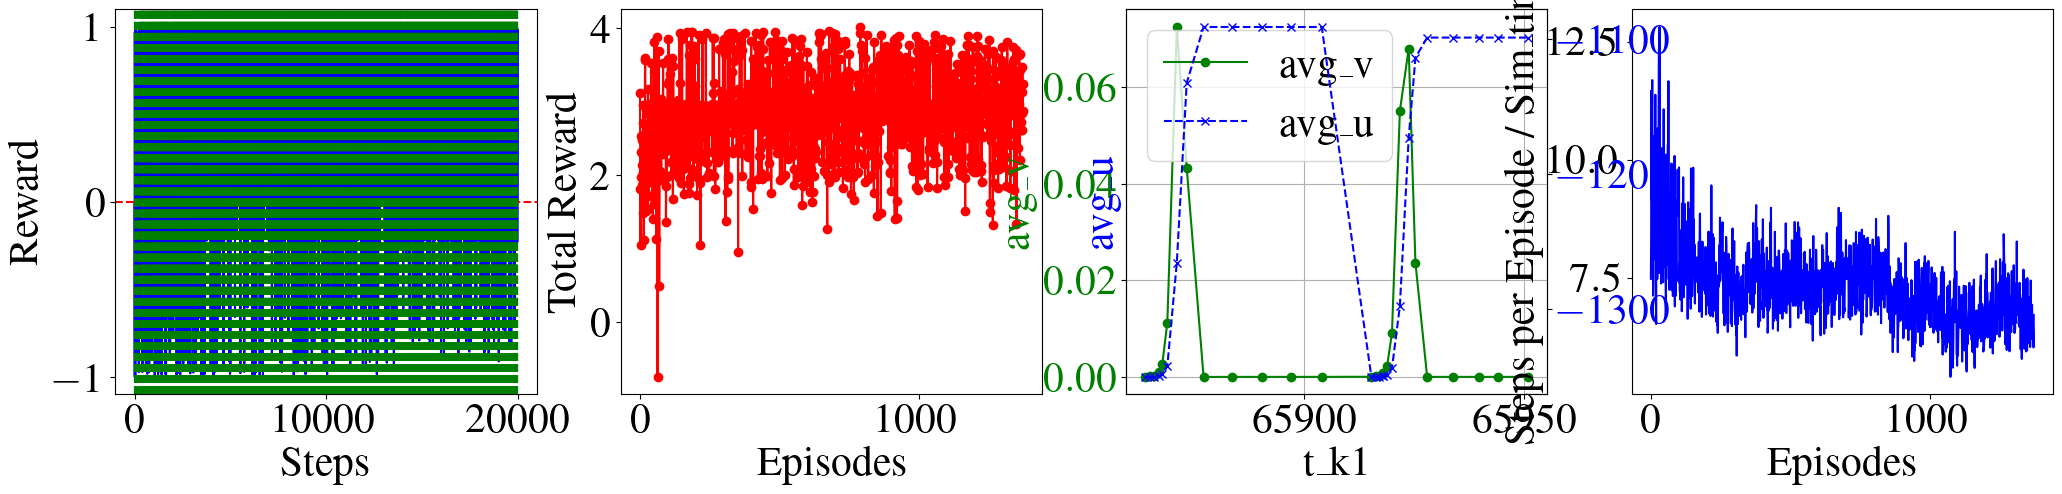

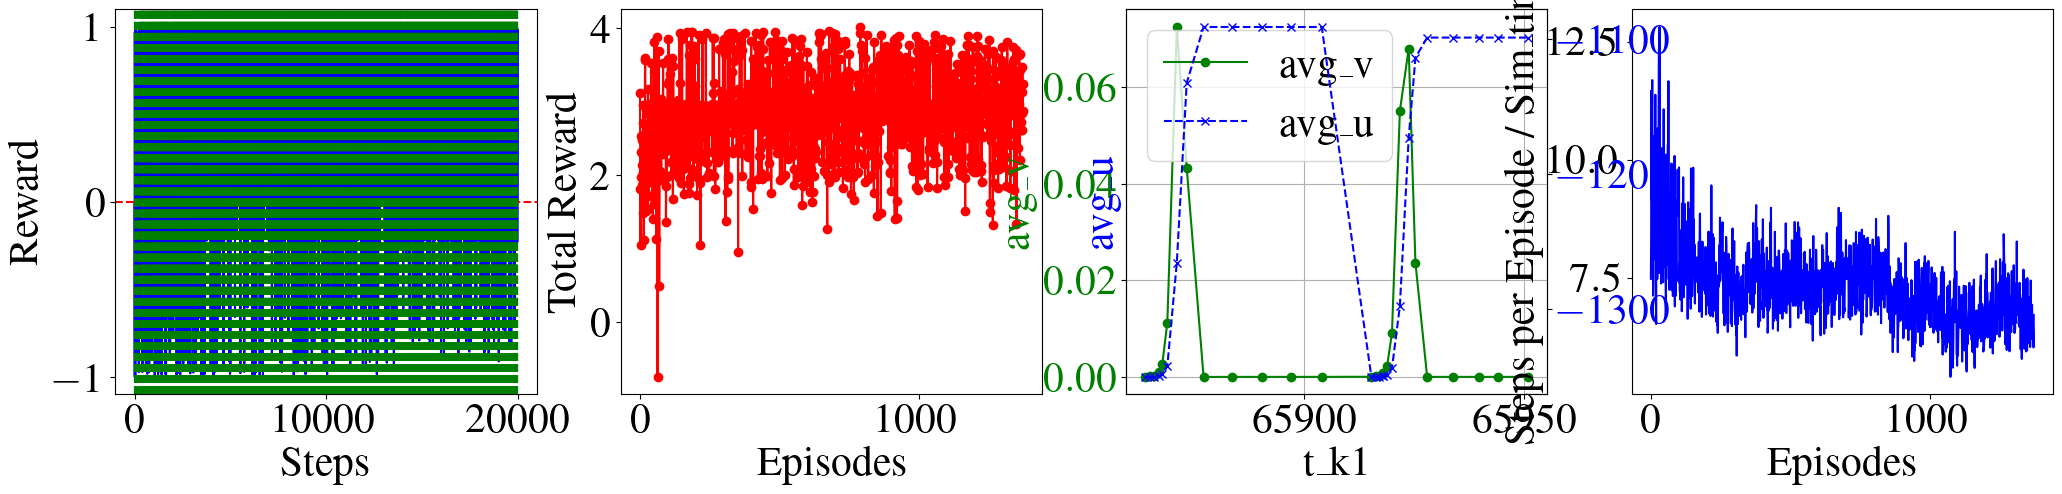

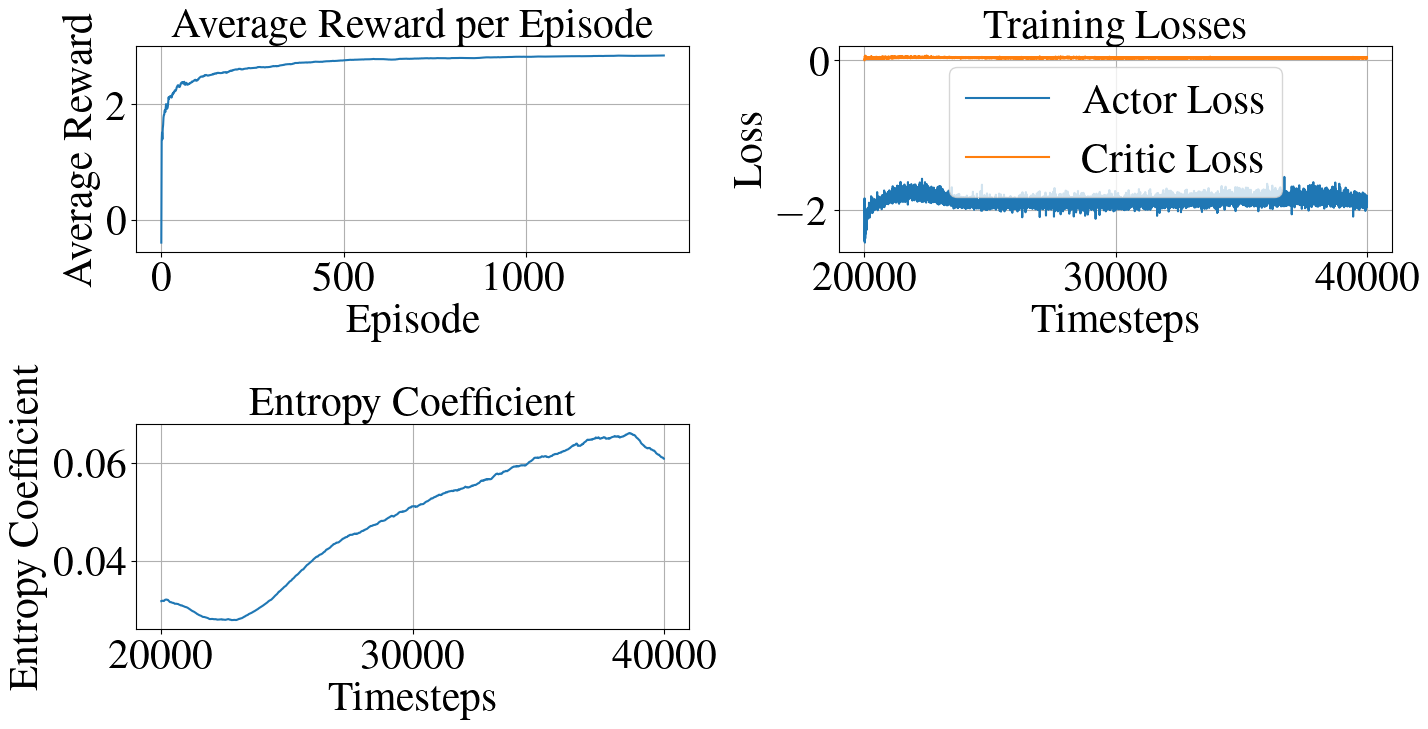

Additional training complete in 10914.98 seconds.
Saved continued model to TEST_RL_ALPHA_SWEEP/alpha_4p0/TQC/model_resume
Saved VecNormalize stats to TEST_RL_ALPHA_SWEEP/alpha_4p0/TQC/vec_norm_resume.pkl
Updated metadata at TEST_RL_ALPHA_SWEEP/alpha_4p0/TQC/metadata.json


In [18]:
MODEL_CLASS_MAP = {
    "TQC": TQC,
    # "TD3": TD3,
}

def _make_training_env(alpha_value: float):
    """Return a factory that builds the AdaptiveStepperEnv for the given alpha."""
    reward_fn = build_reward_fn(alpha_value)
    obs_fn = build_obs_fn(alpha_value)

    def _factory():
        return AdaptiveStepperEnv(
            system=rhs,
            dt0=dt0,
            t0=t0,
            x0=y0,
            tnmax=tnmax,
            dt_min=dt_min,
            dt_max=dt_max,
            nparams=nparams,
            integrator=method_mp,
            component_slices=component_slices,
            reward_fn=reward_fn,
            obs_fn=obs_fn,
            obs_space=obs_space,
            verbose=False,
            alpha=alpha_value,
        )
    return _factory

def continue_training_from_checkpoint(
    alpha_value: float = 4.0,
    algo_name: str = "TQC",
    additional_timesteps: int = 20_000,
    save_suffix: str | None = "resume",
    run_root: Path = RUN_ROOT,
    device: str = "cuda",
):
    """Resume training from a previously saved model/checkpoint."""
    model_cls = MODEL_CLASS_MAP.get(algo_name)
    if model_cls is None:
        raise KeyError(f"Unsupported algorithm '{algo_name}'.")

    alpha_dir = run_root / f"alpha_{_alpha_label(alpha_value)}"
    run_dir = alpha_dir / algo_name
    if not run_dir.exists():
        raise FileNotFoundError(f"No directory found for {run_dir}.")

    model_path = run_dir / "model.zip"
    if not model_path.exists():
        model_path = run_dir / "model"
    if not model_path.exists():
        raise FileNotFoundError(f"Missing model file under {run_dir}.")

    vecnorm_path = run_dir / "vec_norm.pkl"
    meta_path = run_dir / "metadata.json"

    env_factory = _make_training_env(alpha_value)
    base_vec_env = DummyVecEnv([env_factory])
    if vecnorm_path.exists():
        vec_env = VecNormalize.load(str(vecnorm_path), base_vec_env)
    else:
        vec_env = VecNormalize(base_vec_env, norm_obs=False, norm_reward=False)
    vec_env.training = True
    vec_env.norm_obs = False
    vec_env.norm_reward = False

    model = model_cls.load(str(model_path), device=device)
    model.set_env(vec_env)

    transfer_reward_cb = RewardCallback(
        num_envs=1,
        Vscale=fault.Vscale,
        Dscale=fault.Dscale,
        Tscale=fault.Tscale / fault.second,
        update_freq=100,
    )
    metrics_callback = CustomMetricsCallback()

    print(f"Resuming {algo_name} training for alpha={alpha_value} from {model_path}...")
    start = time.time()
    model.learn(
        total_timesteps=additional_timesteps,
        callback=[transfer_reward_cb, metrics_callback],
        reset_num_timesteps=False,
    )
    elapsed = time.time() - start
    print(f"Additional training complete in {elapsed:.2f} seconds.")

    if save_suffix is None:
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        save_suffix = f"resume_{timestamp}"
    model_save_path = run_dir / f"model_{save_suffix}"
    vecnorm_save_path = run_dir / f"vec_norm_{save_suffix}.pkl"
    model.save(str(model_save_path))
    vec_env.save(str(vecnorm_save_path))
    print(f"Saved continued model to {model_save_path}")
    print(f"Saved VecNormalize stats to {vecnorm_save_path}")

    meta = {}
    if meta_path.exists():
        with open(meta_path, "r", encoding="utf-8") as fh:
            meta = json.load(fh)

    prev_timesteps = int(meta.get("total_timesteps", 0))
    meta["total_timesteps"] = prev_timesteps + additional_timesteps
    continuation_log = meta.setdefault("continuations", [])
    continuation_log.append({
        "additional_timesteps": additional_timesteps,
        "save_suffix": save_suffix,
        "elapsed_seconds": elapsed,
        "timestamp": time.strftime("%Y-%m-%dT%H:%M:%S"),
    })
    meta["last_model_path"] = str(model_save_path.with_suffix(".zip"))
    meta["last_vecnorm_path"] = str(vecnorm_save_path)

    with open(meta_path, "w", encoding="utf-8") as fh:
        json.dump(meta, fh, indent=2)
    print(f"Updated metadata at {meta_path}")

    vec_env.close()
    del vec_env, model

# Example usage: resume TQC training for alpha = 8.0 for another 50k timesteps
continue_training_from_checkpoint(alpha_value=4.0, algo_name="TQC", additional_timesteps=20_000)

Evaluating TQC alpha=0.5 from alpha_0p5/TQC...
Finished TQC alpha=0.5: avg_wall=0.354s ± 0.000s, steps=12, t_end=36.62043856345311, converged_any=True
Evaluating TQC alpha=128 from alpha_128p0/TQC...
Finished TQC alpha=128: avg_wall=0.353s ± 0.000s, steps=12, t_end=39.91776797683772, converged_any=True
Evaluating TQC alpha=16 from alpha_16p0/TQC...
Finished TQC alpha=16: avg_wall=0.321s ± 0.000s, steps=12, t_end=38.851501152986216, converged_any=True
Evaluating TQC alpha=1 from alpha_1p0/TQC...
Finished TQC alpha=1: avg_wall=0.334s ± 0.000s, steps=13, t_end=40.82786129966553, converged_any=True
Evaluating TQC alpha=2 from alpha_2p0/TQC...
Finished TQC alpha=2: avg_wall=0.314s ± 0.000s, steps=12, t_end=37.33216228969443, converged_any=True
Evaluating TQC alpha=32 from alpha_32p0/TQC...
Finished TQC alpha=32: avg_wall=0.356s ± 0.000s, steps=12, t_end=36.6742128944401, converged_any=True
Evaluating TQC alpha=4 from alpha_4p0/TQC...
Finished TQC alpha=4: avg_wall=0.326s ± 0.000s, steps=11,

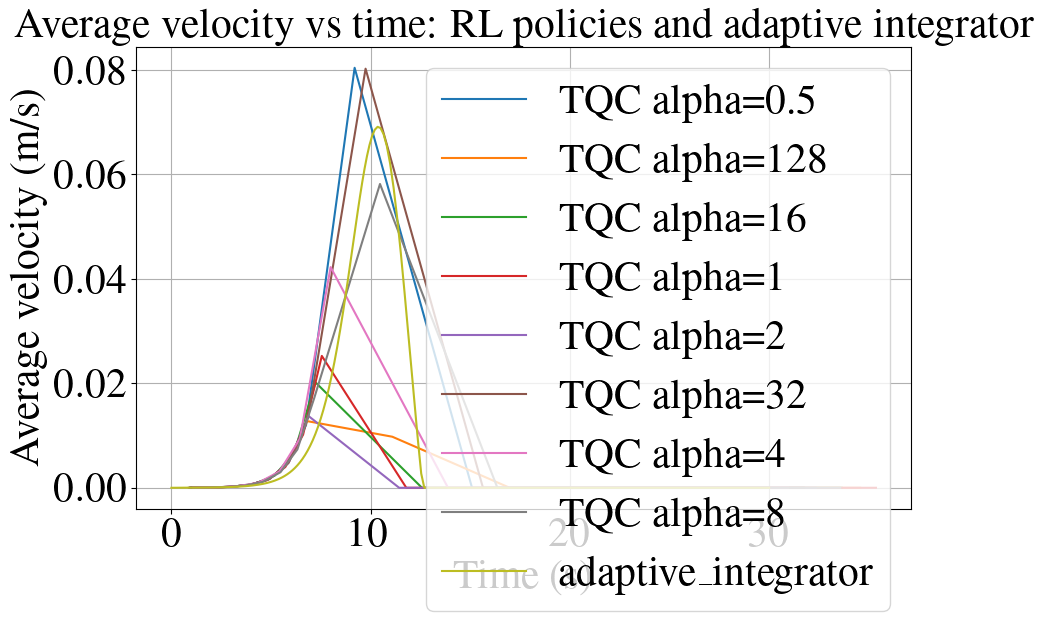

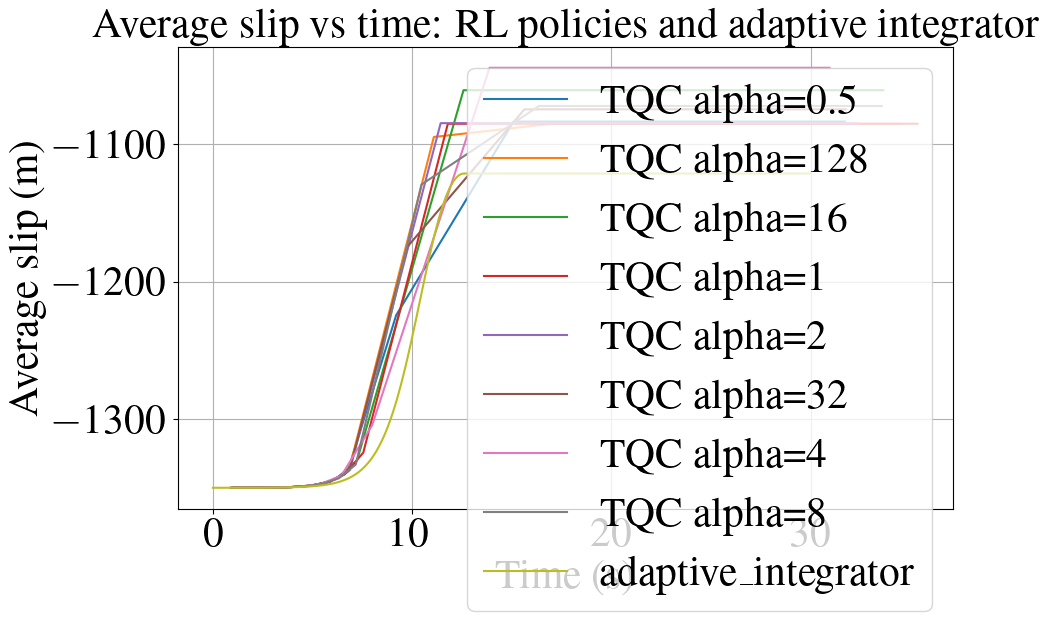

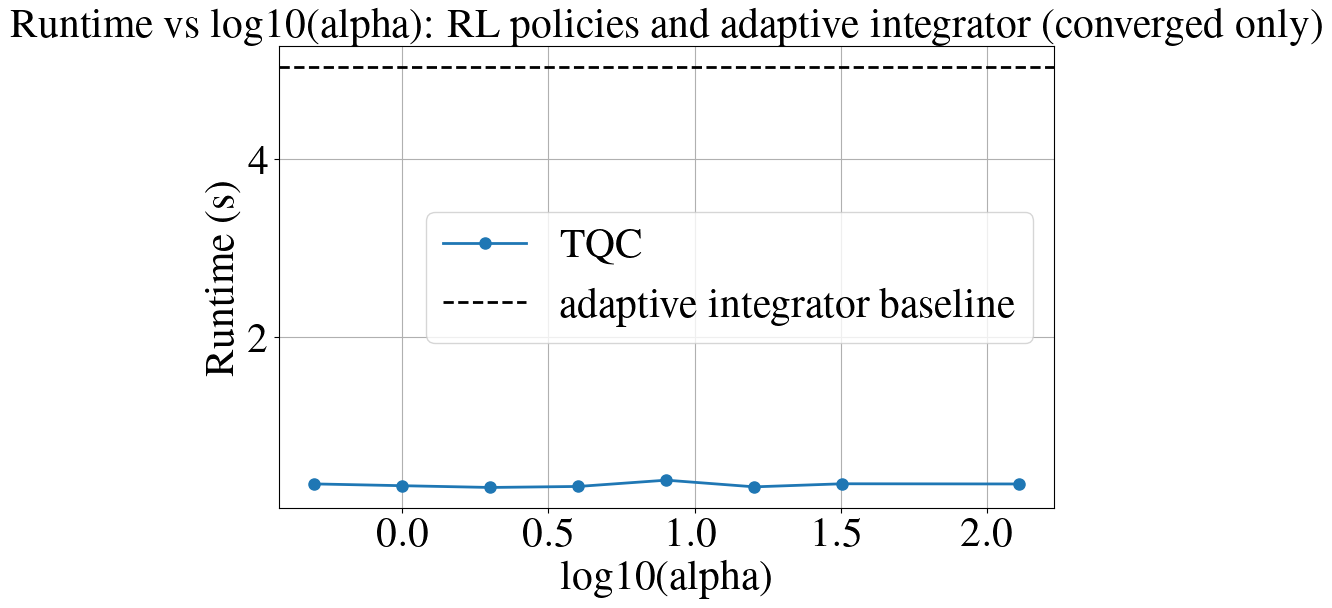

Runtime summary (seconds):


,method,wall_time_s,converged
0,TQC alpha=2,0.314330,True
1,TQC alpha=16,0.321150,True
2,TQC alpha=4,0.325671,True
3,TQC alpha=1,0.334114,True
4,TQC alpha=128,0.353497,True
5,TQC alpha=0.5,0.354270,True
6,TQC alpha=32,0.355808,True
7,TQC alpha=8,0.396178,True
8,adaptive_integrator,5.025590,True


In [18]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from sb3_contrib import TQC
from stable_baselines3 import TD3
import time
try:
    import pandas as pd
    from IPython.display import display
    _HAVE_PANDAS = True
except Exception:
    _HAVE_PANDAS = False

adaptive_opts = dict(
    h0=5e-3,
    h_min=1e-7,
    h_down=0.6,
    h_up=1.8,
    method_order=1,        # p = 1 → nonsmooth first-order scheme, so k = p+1 = 2
    controller="H211b",   # <--- THIS picks the PI digital filter variant to test
    b_param=4.0,         # only if controller == "H211b"
    skip_error_indices=[],
)


# Utility: format alpha subfolder names identical to training
def _alpha_label(alpha_value: float) -> str:
    sign = "m" if alpha_value < 0 else ""
    magnitude = str(abs(alpha_value)).replace(".", "p")
    return f"{sign}{magnitude}"

RUN_ROOT = Path("TEST_RL_ALPHA_SWEEP").resolve()

ALGO_REGISTRY = {
    "TQC": TQC,
    # "TD3": TD3,
}

# Discover trained runs from disk (alpha_* folders)
alpha_dirs = sorted([p for p in RUN_ROOT.glob("alpha_*") if p.is_dir()])
if not alpha_dirs:
    raise FileNotFoundError(f"No trained runs found under {RUN_ROOT}. Expected folders like alpha_1p0/TQC, alpha_10p0/TD3, ...")
dt0 = 1e-3
# Helper to rebuild the same environment used for training
def make_eval_env(reward_fn, obs_fn, alpha_value: float):
    return AdaptiveStepperEnv(
        system=rhs,
        dt0=dt0,
        t0=0.0,
        x0=y0,
        tnmax=tnmax,
        dt_min=dt_min,
        dt_max=dt_max,
        nparams=nparams,
        integrator=method_mp,
        component_slices=component_slices,
        reward_fn=reward_fn,  # not used in deterministic rollout, but env expects it
        obs_fn=obs_fn,
        obs_space=obs_space,
        verbose=False,
        # atol=1e-8,
        # rtol=1e-6,
        alpha=alpha_value,   # ensure env.alpha is set (for completeness)
)

def rollout_policy_on_env(model, env, run_name="(unnamed)"):
    obs, info = env.reset()
    times = []
    mean_vel = []
    mean_slip = []
    start = time.time()
    done = False
    term = False
    # Repeated-time guard
    last_t = None
    repeat_count = 0
    broke_stuck = False
    last_converged = None
    while not (done or term):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, term, info = env.step(action)
        t_now = info.get("t_k1", np.nan)
        # Track last converged flag if provided by env
        if isinstance(info, dict) and ("converged" in info):
            last_converged = info.get("converged")
        # Check for repeated time values to avoid infinite loops
        current_t = None if t_now is None or np.isnan(t_now) else float(t_now)
        if current_t is not None:
            if last_t is not None and np.isclose(current_t, last_t, rtol=0.0, atol=1e-12):
                repeat_count += 1
                if repeat_count >= 10:
                    print(f"[{run_name}] WARNING: Time stuck at {current_t} for 10 iterations, breaking loop")
                    broke_stuck = True
                    break
            else:
                repeat_count = 0  # Reset counter if time advances
            last_t = current_t
        xk = info.get("xk", None)
        if xk is not None:
            n = N_DOFS
            v = xk[:n]
            u = xk[n:2*n]
            times.append(float(t_now))
            mean_vel.append(float(np.mean(v)))
            mean_slip.append(float(np.mean(u)))
    wall = time.time() - start

    # Determine success: p2fer env-provided converged, else reach tnmax and not stuck
    tnmax_val = getattr(env, 'tnmax', None)
    if last_converged is not None:
        success = bool(last_converged)
    else:
        if len(times) > 0 and tnmax_val is not None:
            success = (times[-1] >= 0.999 * float(tnmax_val)) and not broke_stuck
        else:
            success = not broke_stuck

    # Convert to arrays
    return np.asarray(times), np.asarray(mean_vel), np.asarray(mean_slip), wall, success

# Storage for plotting and table
series = {}  # key -> dict(times, mean_v, mean_u, runtime)

for alpha_dir in alpha_dirs:
    algo_dirs = sorted([p for p in alpha_dir.iterdir() if p.is_dir()])
    if not algo_dirs:
        print(f"Skipping {alpha_dir.name}: no algorithm runs found")
        continue
    for algo_dir in algo_dirs:
        algo_name = algo_dir.name
        ModelClass = ALGO_REGISTRY.get(algo_name)
        if ModelClass is None:
            print(f"Skipping {algo_dir}: unknown algorithm '{algo_name}'")
            continue
        meta_path = algo_dir / "metadata.json"
        model_path_zip = algo_dir / "model.zip"
        model_path_plain = algo_dir / "model"

        if not meta_path.exists():
            print(f"Skipping {algo_dir}: missing metadata.json")
            continue
        with open(meta_path, "r", encoding="utf-8") as fh:
            meta = json.load(fh)
        alpha_value = float(meta.get("alpha", np.nan))
        if np.isnan(alpha_value):
            # Try to parse from parent folder name: alpha_1p0 -> 1.0
            try:
                alabel = alpha_dir.name.split("alpha_")[-1]
                alpha_value = float(alabel.replace("p", ".").replace("m", "-"))
            except Exception:
                print(f"Could not infer alpha from {alpha_dir.name}; skipping {algo_dir}")
                continue

        key = f"{algo_name} alpha={alpha_value:g}"
        print(f"Evaluating {key} from {(algo_dir.relative_to(RUN_ROOT))}...")

        # Build reward/obs EXACTLY as training for this alpha
        reward_fn = build_reward_fn(alpha_value)
        obs_fn = build_obs_fn(alpha_value)
        env = make_eval_env(reward_fn, obs_fn, alpha_value)

        mdl_path = str(model_path_zip) if model_path_zip.exists() else str(model_path_plain)
        if not Path(mdl_path).exists():
            print(f"Skipping {algo_dir}: no model found at {model_path_zip} or {model_path_plain}")
            continue
        model = ModelClass.load(mdl_path, device="cpu")

        # Rollout - average over 10 runs for robust runtime measurement
        try:
            runtimes = []
            success_runs = []
            for run_idx in range(1):
                t_arr, v_mean, u_mean, wall, success = rollout_policy_on_env(model, env, run_name=key)
                runtimes.append(wall)
                success_runs.append(bool(success))
                if run_idx == 0:
                    # Store trajectory data from first run only
                    t_arr_store = t_arr
                    v_mean_store = v_mean
                    u_mean_store = u_mean
            avg_runtime = np.mean(runtimes)
            std_runtime = np.std(runtimes)
            any_success = any(success_runs)
            print(f"Finished {key}: avg_wall={avg_runtime:.3f}s ± {std_runtime:.3f}s, steps={len(t_arr_store)}, t_end={(t_arr_store[-1] if len(t_arr_store)>0 else 'NA')}, converged_any={any_success}")
            series[key] = {
                "times": t_arr_store,
                "mean_v": v_mean_store,
                "mean_u": u_mean_store,
                "runtime_s": float(avg_runtime),
                "runtime_std": float(std_runtime),
                "converged": bool(any_success),
            }
        except Exception as e:
            print(f"FAILED {key}: {e}")
            continue

# Baseline: adaptive integrator (from earlier SSN run or re-run if needed)
def adaptive_integrator_baseline():
    # Use Solve_IVP_NS.solve_ivp_ns as in the earlier cell
    # Run 10 times for consistent runtime measurement
    runtimes_b = []
    t_store = None
    y_store = None
    for run_idx in range(1):
        try:
            if run_idx == 0:
                # Use cached values for first run if available
                t_vals_b = t_vals_ssn
                y_vals_b = y_vals_ssn
                wall_b = rt_nb
            else:
                raise NameError  # Force re-run for timing
        except NameError:
            start_b = time.time()
            projection_opts_nb = dict(projection_opts)
            projection_opts_nb['use_numba'] = True
            (t_vals_b, y_vals_b, h_vals_b, fk_vals_b, solver_info_b) = Solve_IVP_NS.solve_ivp_ns(
                fun=rhs,
                t_span=t_span,
                y0=y0,
                method='composite',
                projection='coulomb',
                solver='VI',
                projection_opts=projection_opts_nb,
                solver_opts=solver_opts_ssn,
                adaptive=True,
                adaptive_opts=adaptive_opts,
                # atol=1e-8,
                # rtol=1e-6,
                h0=adaptive_opts['h0'],
                component_slices=component_slices,
                verbose=False,
                A=A,
            )
            wall_b = time.time() - start_b
        runtimes_b.append(wall_b)
        if run_idx == 0:
            # Store trajectory from first run
            t_store = t_vals_b
            y_store = y_vals_b
    
    n = N_DOFS
    v_b = np.mean(y_store[:, :n], axis=1)
    u_b = np.mean(y_store[:, n:2*n], axis=1)
    avg_runtime_b = np.mean(runtimes_b)
    std_runtime_b = np.std(runtimes_b)
    print(f"Adaptive integrator: avg_wall={avg_runtime_b:.3f}s ± {std_runtime_b:.3f}s")
    # Treat baseline as converged if it reaches end time
    success_b = (len(t_store) > 0 and t_store[-1] >= 0.999 * t_span[1])
    return t_store, v_b, u_b, avg_runtime_b, std_runtime_b, success_b

t_b, v_b, u_b, wall_b, wall_b_std, succ_b = adaptive_integrator_baseline()
series["adaptive_integrator"] = {
    "times": np.asarray(t_b),
    "mean_v": np.asarray(v_b),
    "mean_u": np.asarray(u_b),
    "runtime_s": float(wall_b),
    "runtime_std": float(wall_b_std),
    "converged": bool(succ_b),
}

# Plot velocity
plt.figure(figsize=(10,6))
for name, data in series.items():
    t_plot = data["times"] * fault.Tscale / fault.second
    v_plot = data["mean_v"] * fault.Vscale
    plt.plot(t_plot, v_plot, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Average velocity (m/s)")
plt.title("Average velocity vs time: RL policies and adaptive integrator")
plt.grid(True)
plt.legend()
plt.show()

# Plot slip
plt.figure(figsize=(10,6))
for name, data in series.items():
    t_plot = data["times"] * fault.Tscale / fault.second
    u_plot = data["mean_u"] * fault.Dscale
    plt.plot(t_plot, u_plot, label=name)
plt.xlabel("Time (s)")
plt.ylabel("Average slip (m)")
plt.title("Average slip vs time: RL policies and adaptive integrator")
plt.grid(True)
plt.legend()
plt.show()

# Plot runtime vs log10(alpha) — skip non-converged entries
from collections import defaultdict
runtime_by_algo = defaultdict(list)
baseline_runtime = None

for name, data in series.items():
    # Extract alpha from the key name (e.g., "TQC alpha=1.0")
    if "alpha=" in name:
        parts = name.split("alpha=")
        algo = parts[0].strip()
        alpha = float(parts[1])
        if data.get("converged", True):  # only include converged runs
            runtime = data["runtime_s"]
            runtime_by_algo[algo].append((alpha, runtime))
    elif "adaptive_integrator" in name:
        if data.get("converged", True):
            baseline_runtime = data["runtime_s"]

if runtime_by_algo:
    plt.figure(figsize=(10, 6))
    for algo_name, pairs in runtime_by_algo.items():
        if not pairs:
            continue
        pairs_sorted = sorted(pairs, key=lambda x: x[0])
        alphas = [p[0] for p in pairs_sorted]
        runtimes = [p[1] for p in pairs_sorted]
        plt.plot(np.log10(alphas), runtimes, marker='o', label=algo_name, linewidth=2, markersize=8)
    
    if baseline_runtime is not None:
        plt.axhline(baseline_runtime, color='k', linestyle='--', linewidth=2, label='adaptive integrator baseline')
    
    plt.xlabel("log10(alpha)")
    plt.ylabel("Runtime (s)")
    plt.title("Runtime vs log10(alpha): RL policies and adaptive integrator (converged only)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Runtime table
rows = [{"method": name, "wall_time_s": data["runtime_s"], "converged": data.get("converged", True)} for name, data in series.items()]
if _HAVE_PANDAS:
    df = pd.DataFrame(rows).sort_values(["converged", "wall_time_s"], ascending=[False, True]).reset_index(drop=True)
    print("Runtime summary (seconds):")
    display(df)
else:
    print("Runtime summary (seconds) — converged first:")
    for row in sorted(rows, key=lambda r: (not r["converged"], r["wall_time_s"])):
        tag = " (failed)" if not row["converged"] else ""
        print(f"- {row['method']}: {row['wall_time_s']:.3f}s{tag}")